In [144]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

from numpy.linalg import norm

from utility_funcs import *

- В склерне оптимальные параметры ядра ищутся не градиентным спуском, а в gpytorch градиентным спуском как внутри pytorch - в этом главное отличие 

- Лосс, который пишется у гпр - это -log likelyhood loss для параметров, которые мы обучаем

- Мы добавляем какие-то параметры, чтобы не делать операции $O(N^3)$, а сделать несколько шагов оптимизации параметров вместе того, чтобы полностью точно считать обратную к K

- в склерне дефолтный кернел - это конст кернел * RBF - короче там 2 параметра обучается

In [145]:
def make_predictions_and_check_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    Качество

    '''

    if data:
        X_matrices, Y_target, *_ = list(map(lambda x: torch.stack(x), list(zip(*data))))

        
    Y_pred = model.predict(X_matrices)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = mean_squared_error(Y_pred, Y_target)

    print(metric)

    return Ys

In [146]:
def formate_data_for_sklearn(data, size_cut=1):

    X = [elem[0].detach().numpy() for elem in data[:len(data) * size_cut]]
    Y = [elem[1].detach().numpy() for elem in data[:len(data) * size_cut]]

    X = np.stack(X)
    Y = np.stack(Y)
    return X, Y

In [147]:
path = './dataset_objects/4_dataset_K_3.pt'

In [148]:
my_kernel = ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) * RBF(1., length_scale_bounds="fixed")  # пока фиксированные параметры
my_kernel

1**2 * RBF(length_scale=1)

In [149]:
data = torch.load(path)

train_data, val_data, *_ = recieve_loaders(path=path, take_one_projection_for_data=0)

train_X, train_Y = formate_data_for_sklearn(train_data)
val_X, val_Y = formate_data_for_sklearn(val_data)

In [150]:
# normer = Normalizer()
# train_X = normer.fit_transform(train_X)
# val_X = normer.transform(val_X)

n_restarts_optimizer - если вдруг может быть несколько оптимумов чтобы несколько раз запустилось и попрбовало найти типо их несколько раз

- Что вообще оптимизируется - поскольку единственная случайно выбранная нами здесь вещь - это функция ядра, то мы как раз и оптимизируем параметры внутри этой функции ядра так, чтобы
мы получали ответы максимально близкие к таргетам. Она оптммизируется путем максимизации минус логарифма правдоподобия для данного параметра при условии данных

In [151]:
gpr = GaussianProcessRegressor(kernel=my_kernel, random_state=0, n_restarts_optimizer=1, normalize_y=True)
gpr.fit(train_X, train_Y)

Y_pred = gpr.predict(val_X, return_std=False)

In [152]:
mean_squared_error(val_Y, Y_pred)

0.012655500688217743

In [153]:
gpr.score(val_X, val_Y)

0.2708351856572241

In [154]:
make_predictions_and_check_quality(model=gpr, data=val_data, same_axis=False)
None

0.012655500688217743


In [155]:
gpr.kernel.get_params()

{'k1': 1**2,
 'k2': RBF(length_scale=1),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 1.0,
 'k2__length_scale_bounds': 'fixed'}

---
Снизу попытки что-то визуализировать:

In [156]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

In [157]:
Y_true = val_Y
Y_pred = gpr.predict(val_X)

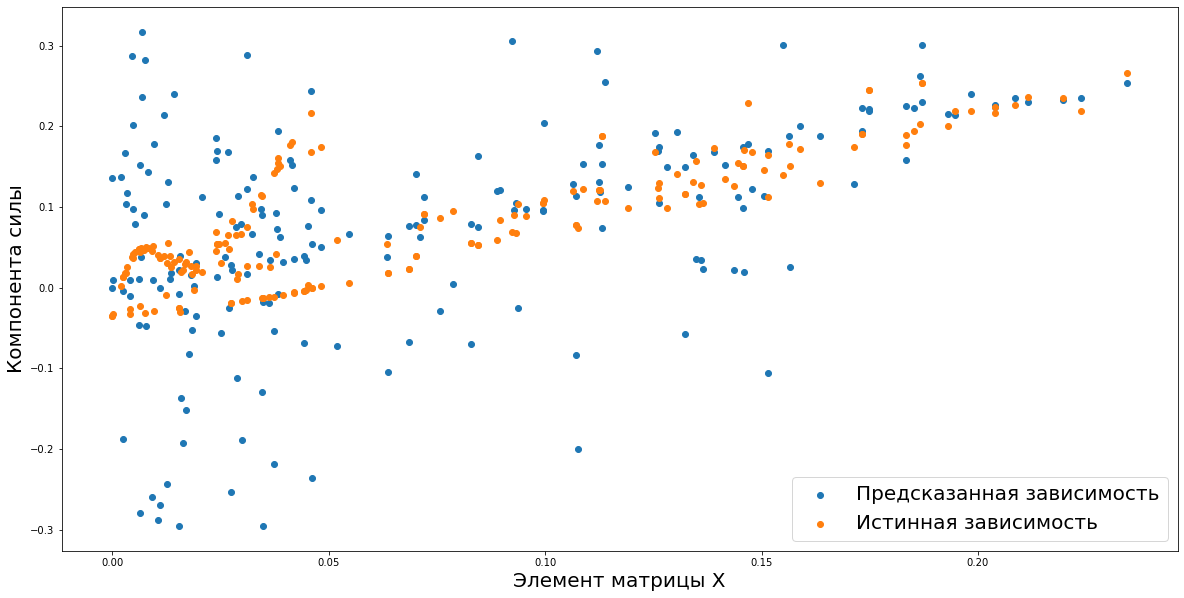

In [158]:
plot_2d_result(x11_val, Y_true, Y_pred, figsize=(20, 10))

In [159]:
train_X[0].reshape((3,3))

array([[0.21152152, 0.        , 0.        ],
       [0.        , 0.06708534, 0.        ],
       [0.        , 0.        , 0.14161293]], dtype=float32)

- типо 4 полосочки потому что 4 частицы

Умные слова что с экспонентой нельзя....

Это типо не просто вектора V_i - это буквально силы...